In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score,precision_recall_curve,classification_report,auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import time

### Площадь под графиком и управление порогом

#### Цель работы

Научиться применять кривые PR и ROC для оценки моделей классификации, использовать их для выбора оптимального порога классификации

#### Содержание работы

1. Сгенерируйте датасет для бинарной классификации, обучите на нем модель логистической регрессии и постройте для этой модели кривые ROC и PR.
1. Вычислите для этой модели метрики площади под кривыми (ROC-AUC и PR-AUC).
1. Обучите на том же датасете другую модель и сравните ее эффективность по кривым и по метрикам.
1. Сгенерируйте датасет для бинарной классификации с большим дисбалансом классов, обучите на нам ту же модель и постройте кривые.
1. Используйте данные, вычисленные для построения кривых для нахождения оптимального значения порога модели. Постройте матрицу классификации для модели с порогом по умолчанию и с лучшим порогом. Сравните результаты.

#### Методические указания

Начнем с получение датасета для бинарной классификации. Воспользуемся самым простым вариантом - сгенерируем его:

In [45]:

X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)

Разделим выборку на обучающую и тестовую. В данном случае нам не очень важны будут показатели эффективности моделей, но важно, чтобы и тестовая и обучающая выборки имели достаточное количество точек. Поэтому поделим датасет пополам, хотя на практике такая пропорция не используется:

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

Создадим и обучим на обучающей выборке простую модель логистической регрессии::

In [47]:
model = LogisticRegression().fit(X_train, y_train)

Логистическая регрессия, наряду со многими другими моделями классификации может работать как точечный предиктор (то есть выдавать для входного объекта наиболее вероятный класс), а может - как вероятностный (то есть для данного объекта выдавать оценки вероятности принадлежности к каждому классу, который присутствует в обучающей выборке). Сейчас мы поработаем как раз с этими вероятностями. Получить их очень легко, воспользуемся специальным методом:

In [48]:
y_pred_proba = model.predict_proba(X_test)

Мы получили матрицу вероятностей:

In [49]:
y_pred_proba

array([[4.02958497e-03, 9.95970415e-01],
       [2.00643855e-03, 9.97993561e-01],
       [9.94696564e-01, 5.30343592e-03],
       [8.47909962e-01, 1.52090038e-01],
       [1.66614096e-03, 9.98333859e-01],
       [4.99240075e-01, 5.00759925e-01],
       [9.80208762e-01, 1.97912375e-02],
       [9.76507391e-01, 2.34926092e-02],
       [1.79866697e-02, 9.82013330e-01],
       [2.93132539e-01, 7.06867461e-01],
       [9.95836132e-01, 4.16386810e-03],
       [2.53456369e-01, 7.46543631e-01],
       [9.92314475e-01, 7.68552501e-03],
       [3.80237693e-02, 9.61976231e-01],
       [6.47256719e-02, 9.35274328e-01],
       [1.91873737e-01, 8.08126263e-01],
       [8.55142720e-01, 1.44857280e-01],
       [4.34150814e-02, 9.56584919e-01],
       [8.43060465e-01, 1.56939535e-01],
       [5.51009943e-02, 9.44899006e-01],
       [1.32996996e-01, 8.67003004e-01],
       [5.89343759e-01, 4.10656241e-01],
       [9.79492824e-01, 2.05071761e-02],
       [3.32717535e-01, 6.67282465e-01],
       [9.957351

В этой матрице количество строк совпадает с количеством объектов, которые мы передали методу (в данном случае мы передали всю тестовую выборку). Для каждого объекта в матрице указано два значения - вероятности его отнесения, по мнению модели, соответственно, к отрицательному и положительному классу. Так как задача у нас бинарная, можно заметить, что эти два числа всегда дают в сумме единицу. В общем случае, для множественной классификации, это не обязательно выполняется. Но в даннос случае нам дальше вообще понадобится только второй столбец этой матрицы.

Для построения кривой ROC используем встроенную в _sklearn_ функцию _roc\_curve_, которая находится в пакете _metrics_:

In [50]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

Данная функция возвражает три массива: значения метрики FPR (false positive rate), TPR (true positive rate) и значение порога. Фактически, данная функция берет определенное количество значений порога (в промежутке от 0 до 1), применяет данный порог для точной классификации, исходя из переданной ей матрицы вероятностей, и вычисляет при данном значении порога две упомянутые метрики.

Значения порога нас пока не очень интересуют, а первые два массива мы используем для построения графика - того самомго ROC:

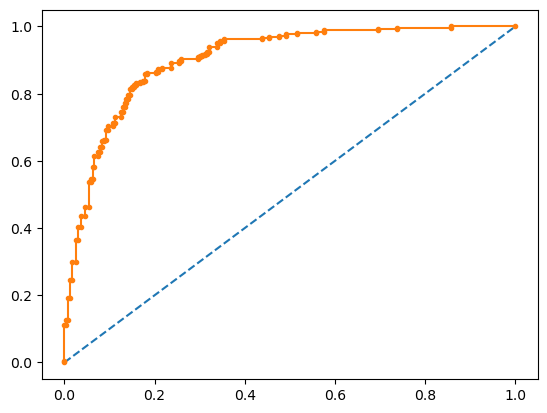

In [51]:
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

Здесь мы значала рисуем прямую между точками (0,0) и (1, 1) - это референсная линия, которая представляет условный тривиальный классификатор. Именно с ней мы будем сравнивать получившуюся кривую, А она должна распологаться примено так:

![](https://github.com/koroteevmv/ML_course/blob/main/ML4.2%20threshold/img/ml42-1.png?raw=true)

Из графика мы видим, что кривая находится выше прямой, что свидетельствует о том, что классификатор работает лучше, чем случайное предсказание. Но можно заметить, что при разных значениях порога (зеленые точки на графике) модель имеет значительно различающиеся характеристики. И только одна точка на этом графике характеризует поведение модели при "дефолтном" значении порога - то, что мы обычно не задумываясь получаем методом _predict_.

Но анализ графика может нам дать только примерное представление о том, насколько хороша модель. Особенно сейчас, когда нам не с чем ее сравнить. Боле четкую оценку даст метрика ROC-AUC, измеряющая площадь под графиком данной кривой. Эту метрику также легко получить:

In [52]:
roc_auc_score(y_test, y_pred_proba[:, 1])

0.9027724358974359

В данном случае, мы имеем значение примерно в 90,3%, что можно интерпретировать как общее качество модели вне зависимости от выбранного порога.

Давайте по аналогии построим график PR-кривой. Из лекции мы знаем, что он строится по аналогичному признаку, но в других координатах. Конечно, библиотека _sklearn_ и здесь позволяет пользоваться готовыми функциями:

In [53]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])

Обратите внимание, что в этих координатах (precision и recall) эффективность тривиального классификатора уже не так примитивна и ависит от соотношения классов в обучающей выборке. Мы уже говорили об этом на лекции. Вот как просто можно его изобразить:

А теперь можно вывести на график и саму кривую PR:

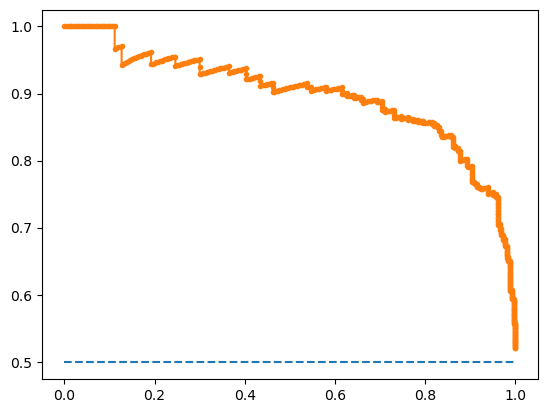

In [54]:
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.show()

![](https://github.com/koroteevmv/ML_course/blob/main/ML4.2%20threshold/img/ml42-2.png?raw=true)

Точно также, как и с ROC можно вычислить соответствующую численную метрику - площадь под графиком PR-кривой - PR-AUC:

In [55]:
auc(recall, precision)

0.897662372903334

Эта метрика численно чуть ниже - порядка 89,8%. Еще это число называют средней точностью модели - average precision.

Полезно посмотреть, как полученные данные соотносятся с уже знакомыми нам характеристиками классификации. Давайте построим отчет о классификации по данной модели:

In [56]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       240
           1       0.84      0.85      0.84       260

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



Важно понимать, что данный отчет характеризует поведение модели только в одной точке - при значении порога, равном по умолчанию 0,5. Кривые же показывают, как модель будет работать при все возможных значениях порога.

Давайте для сравнения попробуем обучить на этих же данных другую модель. Например, метод ближайших сосдей. Вы можете выбрать любую другую модель (но обратите внимание, что не все модели имеют метод _redict\_proba_, а нам он обязательно понадоится. Почему так, читайте в документации к моделям):

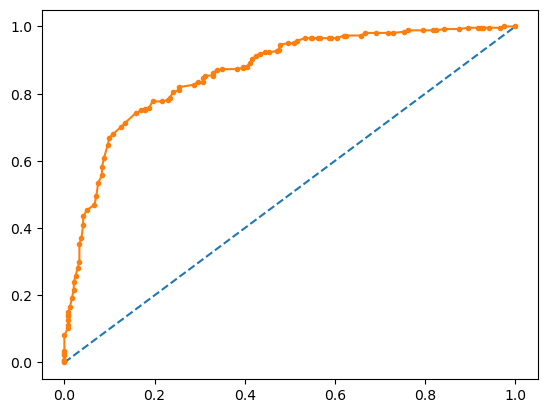

In [57]:
model2 = KNeighborsClassifier(n_neighbors=250).fit(X_train, y_train)
y_pred2_proba = model2.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred2_proba[:, 1])

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

![](https://github.com/koroteevmv/ML_course/blob/main/ML4.2%20threshold/img/ml42-3.png?raw=true)

График будет выглядеть чуть по-другому, но в целом похоже на ROC первой модели. Поэтому для точного сравнения более полезны численные метрики:

In [58]:
roc_auc_score(y_test, y_pred2_proba[:, 1])

0.8630608974358974

Тут явно видно, что ROC-AUC второй модели значимо хуже - 86,3%.

##### Дизбаланс классов

Наиболее явно различия между этими двумя классификационными кривыми - ROC и PR - демонстрирует пример с большим дизбалансом классов. Давайте сгенерируем датасет, в котором объектов разных классов не примерно равное количество, как в предыдущем примере, а объектов отрицательного класса, скажем, 99%. Для этого очень удобно воспользоваться атрибутом _weights_ функции _make\_classification_:

In [59]:
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01], random_state=1)

Также разделим эту выборку на две части. Но сдесь надо быть аккуратными, поэтому сразу выведем объем классов в получившихся частях:

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=4)

print('Датасет: Class0=%d, Class1=%d' % (len(y[y==0]), len(y[y==1])))
print('Обучающая: Class0=%d, Class1=%d' % (len(y_train[y_train==0]), len(y_train[y_train==1])))
print('Тестовая: Class0=%d, Class1=%d' % (len(y_test[y_test==0]), len(y_test[y_test==1])))

Датасет: Class0=985, Class1=15
Обучающая: Class0=490, Class1=10
Тестовая: Class0=495, Class1=5


Видно, что в одной половине выборки положительных объектов в два раза больше, чем в другой. Прислучайном разделении, если есть сильно миноритарные классы, может случиться и не такое. Например, мы можем случайно получить выборку, в которой какие-то классы не представлены вообще. Для предотвращения таких случаев нужно воспользоваться стратификацией:

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

Это агрумент следит за тем, чтобы в обоих частях выборки распределение переданного атрибута было примерно такое же, как и целом датасете. Вот какая картина получается сейчас:

Распределение уже гораздо более равномерное. Для стратификации можно задавать любой массив, не обязательно значение целевой переменной, и разделение произойдет так, чтобы созранить распределение, заданное в этом массиве. Но целевую переменную здесь используют чаще всего.

Точно также, как и в предыдущем примере, обучим модель и сразу вычислим матрицу вероятностей:

In [63]:
model = LogisticRegression().fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)

Сразу познакомимся с дефолтным поведением модели, построив отчет о классификации:

In [64]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       493
           1       0.00      0.00      0.00         7

    accuracy                           0.98       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.98      0.98       500



Здесь мы видим классическую картину обучения на неравномерной выборке. Мажоритарный класс (в данном случае - отрицательный, он у нас в большинстве) распознается очень хорошо, а миноритарный - очень плохо. В нашем случае, вообще по положительному классу все метрики нулевые. Но обратите внимание, что общая точность (accuracy) модели весьма приемлема - 98%. Дизбаланс классов "скрывает" в точности недостатки работы модели.

Построим ROC данной модели:

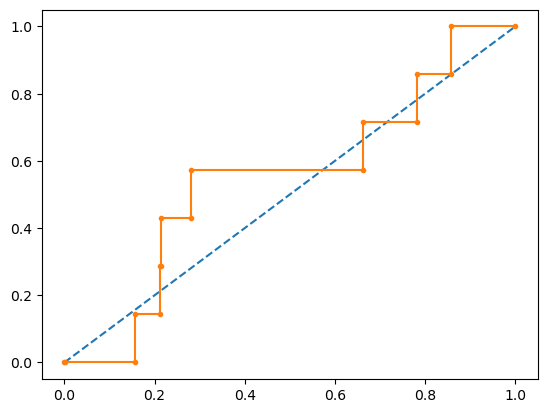

In [65]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

![](https://github.com/koroteevmv/ML_course/blob/main/ML4.2%20threshold/img/ml42-4.png?raw=true)

Мы видим. что вривая показывает не идеальное, но вполне примелемое поведение модели. Средняя точность будет, несомненно, ниже, чем в первом примере работы, но ничего катастрофического мы здесь не наблюдаем. Но давайте построим кривую PR:

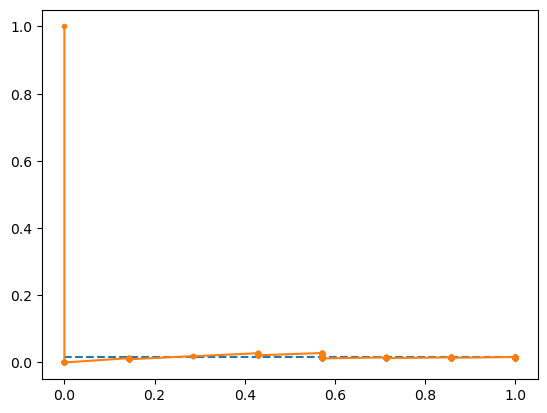

In [66]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.show()

![](https://github.com/koroteevmv/ML_course/blob/main/ML4.2%20threshold/img/ml42-5.png?raw=true)

И вот на этом графике уже открывается истинное поведение модели: она не очень-то отличается от тривиальной, просто чаще предсказывает самый распространенный класс. Так как метрики Precision и Recall специально были созданы для случая несбалансированных классов, именно PR-кривая дает более реалистические оценки эффективности работы моделей классификации на таких данных, где наблюдается большой дисбаланс классов.

##### Выбор значения порога по кривым

Кривые классификации, несомненно, удобный и визуальный способ представления эффективности работы моделей машинного обучения. Но главная их ценность состоит в том, что данные, которые необходимы для их построения могут использоваться для оптимизации порога классификации. Мы уже поняли, что разные значения порога могут приводить к разному поведению моделей и, как следствие, к имзенению метрик. Значит, можно выбрать такой порог, который дает более точную классификацию?

Да, но для этого нам понадобится некоторый критерий - численное значение, которые мы хотим оптимизировать. В лекции мы уже говорили, что простые метрики - precision, recall, accuracy - не очень подходят на роль критерия оптимизации. Но мы можем использовать, например, метрику F1 (и любые метрики из F-семейства). Для этого еще раз сгенерируем датасет, сделаем чуть больше объем данных:

In [67]:
X, y = make_classification(n_samples=10000, n_classes=2, weights=[0.99, 0.01], random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

model = LogisticRegression().fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)

Изобразим PR-кривую:

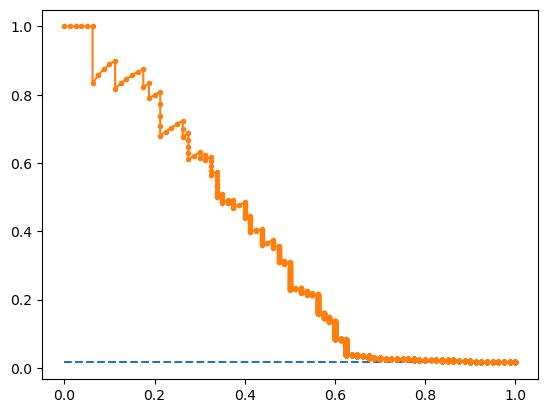

In [68]:
p, r, pr_thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
no_skill = len(y[y==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(r, p, marker='.')
plt.show()

![](https://github.com/koroteevmv/ML_course/blob/main/ML4.2%20threshold/img/ml42-6.png?raw=true)

По точкам на ней мы видим, что при разных значениях порога иногда метрика precision будет больше, иногда - recall. Именно поэтому мы будем оптимизировать по метрике F1. Для этого импортируем из бибилиотеки _numpy_ функцию _argmax_:

In [69]:
from numpy import argmax

Вычислим вектор метрик F1 при всех использованных значениях порога и найдем самое большое значение среди них (вернее, его индекс):

In [70]:
f1 = (2 * p * r) / (p + r)
ix = argmax(f1)
pr_thresholds[ix]

0.12053145297804103

Так как индексы всех массивов, возвращенных функцией _precision\_recall\_curve_ соответственны, по этому индексу получим значение порога и соответствующее ему значение метрики F1:

In [71]:
print('Порог=%f, F-Score=%.3f' % (pr_thresholds[ix], f1[ix]))

Порог=0.120531, F-Score=0.438


Теперь мы можем изобразить эту точку на графике самой кривой:

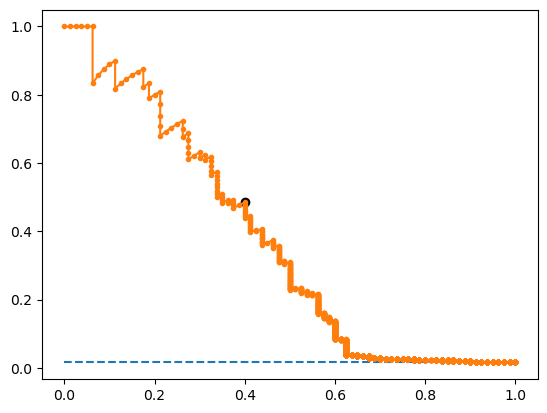

In [72]:
plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
plt.plot(r, p, marker='.')
plt.scatter(r[ix], p[ix], marker='o', color='black')
plt.show()

![](https://github.com/koroteevmv/ML_course/blob/main/ML4.2%20threshold/img/ml42-7.png?raw=true)

Обратите внимание, что мы использовали метрику F1 - это среднее геометрическое между Precision и Recall. При этом эти две метрики имеют равный вклад в среднее. Бывают ситуации, когда нам более приоритетна одна из этих двух метрик. Тогда следует использоваться параметрическую метрику из F-семейства. Мы можем придать в среднем разный вес, то есть больше предпочесть recall или, наоборот, precision.

Давайте используем данное значение порога для проведение непосредственной классификации. Раньше мы так не делали, так как всегда использовали метод _predict_, который всегда использует порог по умолчанию - 0,5. Но точечная классификация - это не что иное, как выбор положительного класса, если модель оценивает вероятность принадлежности к нему выше порога:

In [73]:
y_pred = (y_pred_proba[:, 1] > pr_thresholds[ix]).astype('int')

Полученный вектор значений можно использовать при построении точета о классфикации:

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4920
           1       0.48      0.39      0.43        80

    accuracy                           0.98      5000
   macro avg       0.73      0.69      0.71      5000
weighted avg       0.98      0.98      0.98      5000



А вот для сравнения, отчет о классификации для той же модели, но при использованиии порога по умолчанию:

In [75]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4920
           1       0.89      0.10      0.18        80

    accuracy                           0.99      5000
   macro avg       0.94      0.55      0.59      5000
weighted avg       0.98      0.99      0.98      5000



Самостоятельно проведите сравнение и сделайте вывод об эффективности моделей.

#### Задания для самостоятельного выполнения

##### 1. Повторите анализ из лабораторной работы, но с двумерными датасетами. Изобразите графически, как изменение порога влияет на расположение границы принятия решений.

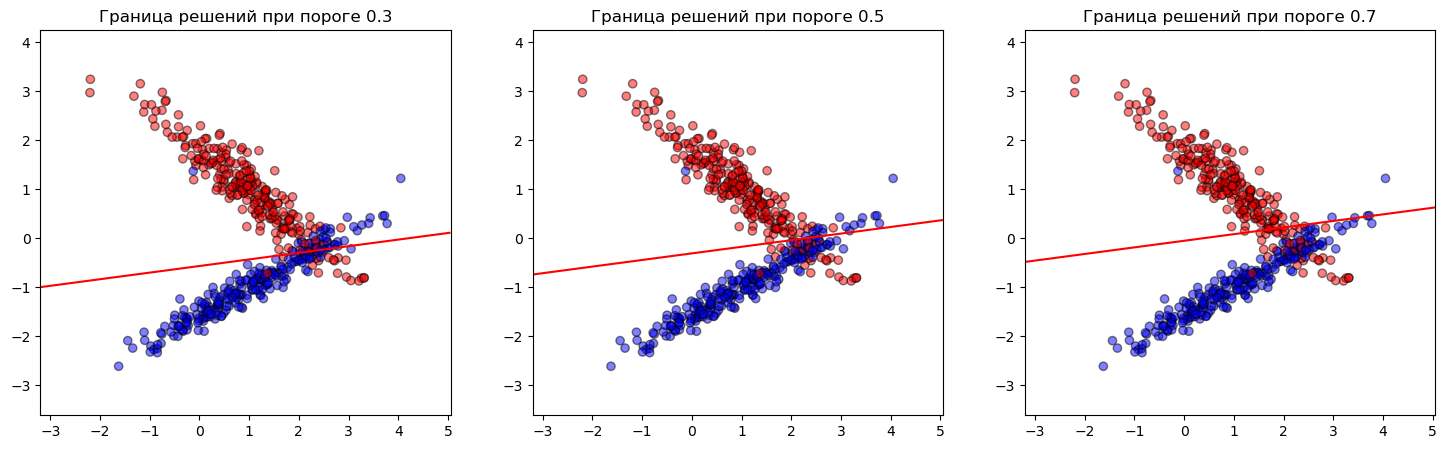

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Генерируем двумерный датасет
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, random_state=42)

# Разбиваем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Обучаем логистическую регрессию
model = LogisticRegression().fit(X_train, y_train)

# Функция для построения границы решений при заданном пороге
def plot_decision_boundary(model, X, y, threshold=0.5, ax=None):
    if ax is None:
        ax = plt.gca()
    # Определяем диапазон для сетки
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    # Получаем вероятности положительного класса
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)
    # Строим контур при заданном пороге
    contour = ax.contour(xx, yy, probs, levels=[threshold], colors='red')
    # Отображаем точки данных
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', alpha=0.5)
    ax.set_title(f'Граница решений при пороге {threshold}')
    return ax

# Строим графики для различных порогов
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, thr in enumerate([0.3, 0.5, 0.7]):
    plot_decision_boundary(model, X_test, y_test, threshold=thr, ax=axs[i])
plt.show()


> При уменьшении порога (например, до 0.3) модель классифицирует больше объектов как положительные, смещая границу решений в сторону уменьшения уверенности. При увеличении порога (до 0.7) граница сдвигается в другую сторону.

##### 2. Повторите анализ на реальном датасете для бинарной классификации. Проинтерпретируйте результат, сделайте вывод.

В данном примере используется датасет рака молочной железы из библиотеки sklearn. Выполняется обучение модели, построение ROC и PR кривых, вычисление AUC и вывод отчёта классификации.

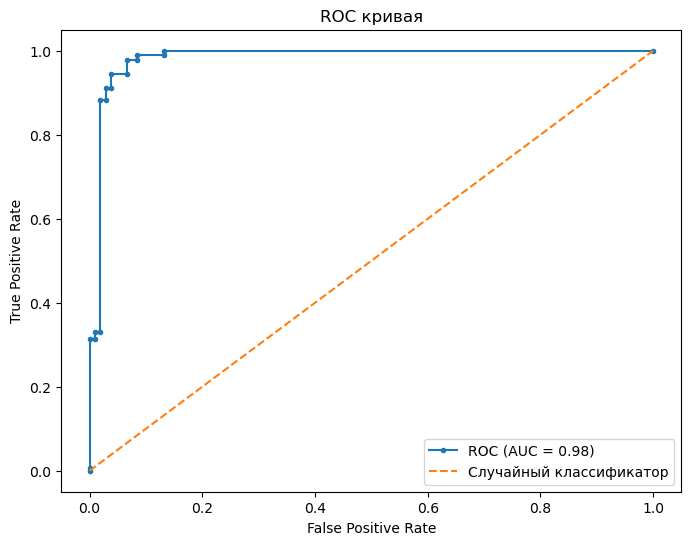

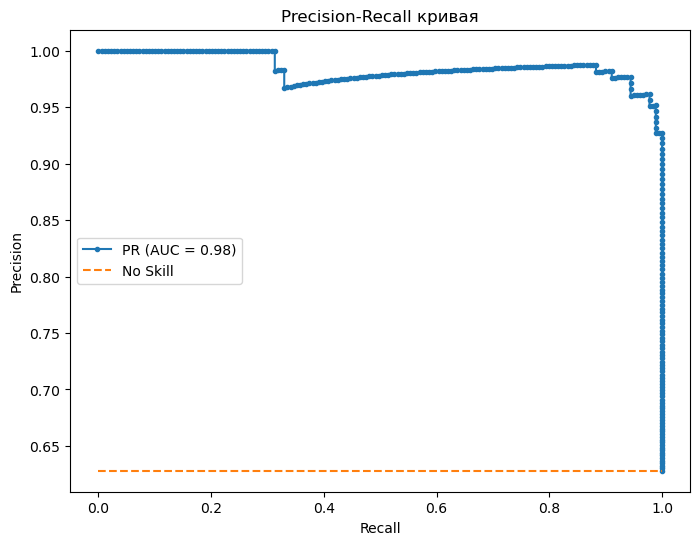

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       106
           1       0.95      0.98      0.96       179

    accuracy                           0.95       285
   macro avg       0.96      0.95      0.95       285
weighted avg       0.95      0.95      0.95       285



In [77]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, classification_report
import matplotlib.pyplot as plt

# Загружаем датасет
data = load_breast_cancer()
X = data.data
y = data.target

# Разбиваем выборку с учетом стратификации
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)

# Обучаем модель
model = LogisticRegression(max_iter=10000).fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# ROC кривая и ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend()
plt.show()

# Precision-Recall кривая и PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'PR (AUC = {pr_auc:.2f})')
no_skill = sum(y_test) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend()
plt.show()

# Отчет классификации для модели с порогом по умолчанию
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

##### 3. В задании по оптимизации порога используйте ROC и среднее геометрическое между TPR и FPR как критерий оптимизации.

Оптимальный порог (ROC, G-mean): 0.632 (TPR=0.978, FPR=0.066, G-mean=0.956)


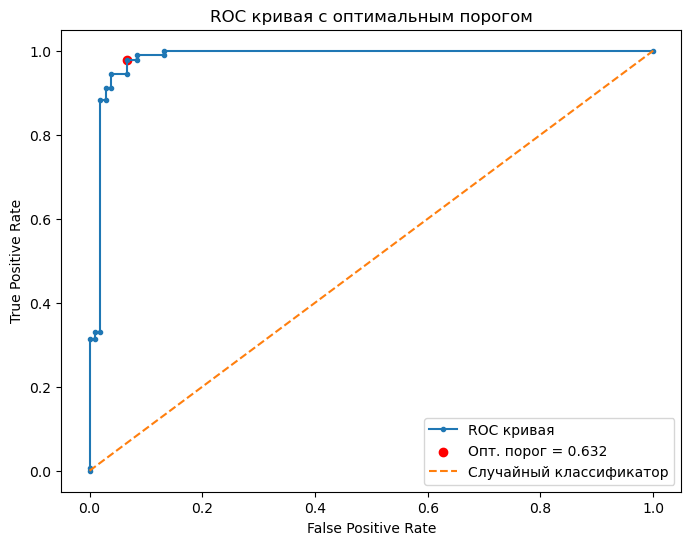

In [78]:
import numpy as np

# Вычисляем ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Вычисляем G-mean: √(TPR * (1 - FPR))
gmean = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmean)
optimal_threshold = thresholds[ix]
print(f'Оптимальный порог (ROC, G-mean): {optimal_threshold:.3f} '
      f'(TPR={tpr[ix]:.3f}, FPR={fpr[ix]:.3f}, G-mean={gmean[ix]:.3f})')

# Визуализация ROC с оптимальной точкой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label='ROC кривая')
plt.scatter(fpr[ix], tpr[ix], color='red', label=f'Опт. порог = {optimal_threshold:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая с оптимальным порогом')
plt.legend()
plt.show()

##### 4. При оптимизации порога по PR-кривой используйте другую F-метрику - сначала с преимуществом precision, а затем - с превалированием recall. Изобразите получившиеся пороги на графике. Проанализируйте метрики получившихся моделей.

Оптимальный порог при β=0.5 (преимущество precision): 0.805, F0.5-score = 0.970
Оптимальный порог при β=2.0 (преимущество recall): 0.190, F2.0-score = 0.985


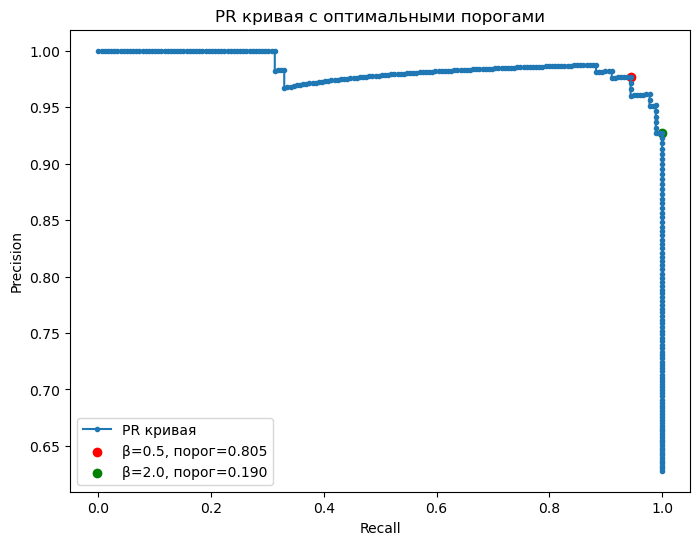

Отчет классификации (преимущество precision):
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       106
           1       0.98      0.94      0.96       179

    accuracy                           0.95       285
   macro avg       0.94      0.95      0.95       285
weighted avg       0.95      0.95      0.95       285

Отчет классификации (преимущество recall):
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       106
           1       0.93      1.00      0.96       179

    accuracy                           0.95       285
   macro avg       0.96      0.93      0.95       285
weighted avg       0.95      0.95      0.95       285



In [79]:
# Вычисляем PR-кривую
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
# Обратите внимание: thresholds_pr имеет длину на 1 меньше, чем precision и recall
thresholds_pr = thresholds_pr

# Функция для вычисления Fβ-меры
def fbeta(prec, rec, beta):
    return (1 + beta**2) * (prec * rec) / ((beta**2 * prec) + rec + 1e-8)

# Вычисляем Fβ для beta=0.5 (преимущество precision) и beta=2 (преимущество recall)
beta1 = 0.5
beta2 = 2.0

f_beta1 = fbeta(precision[:-1], recall[:-1], beta1)
f_beta2 = fbeta(precision[:-1], recall[:-1], beta2)

ix_beta1 = np.argmax(f_beta1)
ix_beta2 = np.argmax(f_beta2)

optimal_threshold_beta1 = thresholds_pr[ix_beta1]
optimal_threshold_beta2 = thresholds_pr[ix_beta2]

print(f'Оптимальный порог при β={beta1} (преимущество precision): {optimal_threshold_beta1:.3f}, F{beta1}-score = {f_beta1[ix_beta1]:.3f}')
print(f'Оптимальный порог при β={beta2} (преимущество recall): {optimal_threshold_beta2:.3f}, F{beta2}-score = {f_beta2[ix_beta2]:.3f}')

# Визуализация PR-кривой с отмеченными оптимальными порогами
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR кривая')
plt.scatter(recall[ix_beta1], precision[ix_beta1], color='red', label=f'β={beta1}, порог={optimal_threshold_beta1:.3f}')
plt.scatter(recall[ix_beta2], precision[ix_beta2], color='green', label=f'β={beta2}, порог={optimal_threshold_beta2:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR кривая с оптимальными порогами')
plt.legend()
plt.show()

# Оценка моделей с оптимизированными порогами
y_pred_beta1 = (y_pred_proba >= optimal_threshold_beta1).astype(int)
y_pred_beta2 = (y_pred_proba >= optimal_threshold_beta2).astype(int)

print("Отчет классификации (преимущество precision):")
print(classification_report(y_test, y_pred_beta1))
print("Отчет классификации (преимущество recall):")
print(classification_report(y_test, y_pred_beta2))

##### 5. Постройте классификационные кривые для задачи множественной классификации. Проинтерпретируйте результат.

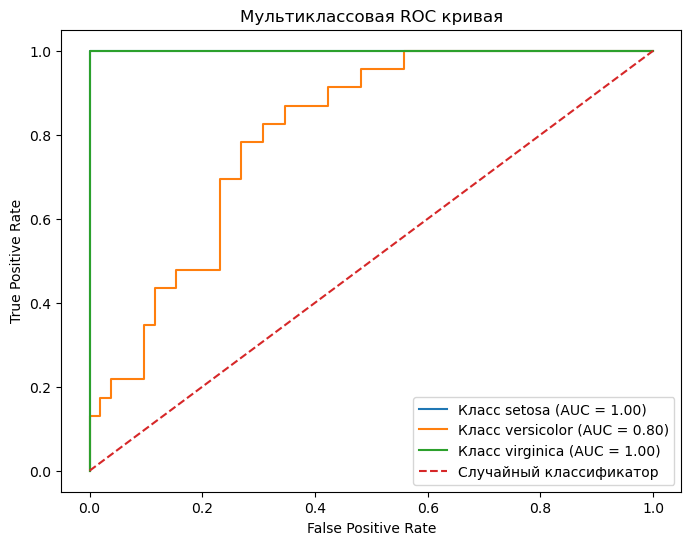

In [80]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# Загружаем датасет Iris
iris = load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Бинаризация меток (для one-vs-rest)
y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

# Разбиваем выборку
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.5, random_state=42)

# Обучаем модель OneVsRest с логистической регрессией
classifier = OneVsRestClassifier(LogisticRegression(max_iter=10000))
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)

# Вычисляем ROC-кривые для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Визуализируем ROC-кривые
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Класс {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Мультиклассовая ROC кривая')
plt.legend()
plt.show()


##### 6. Используйте для построения кривых библиотеку _yellowbrick_.

In [82]:
pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


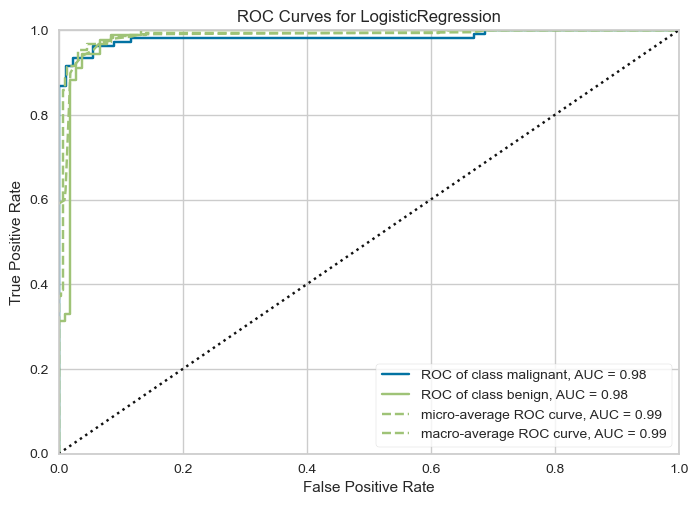

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [1]:
from yellowbrick.classifier import ROCAUC
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Загружаем датасет
data = load_breast_cancer()
X = data.data
y = data.target

# Разбиваем выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)

# Создаем модель
model_yb = LogisticRegression(max_iter=10000)

# Инициализируем визуализатор ROCAUC
visualizer = ROCAUC(model_yb, classes=data.target_names)
visualizer.fit(X_train, y_train)       # Обучаем модель
visualizer.score(X_test, y_test)         # Оцениваем модель и строим график
visualizer.show()

#### Контрольные вопросы

1. Какие модели можно оценивать с помощью классификационных кривых (ROC и PR) и почему именно их?
1. В каких случаях лучше использовать PR-кривую, а в каких - ROC и почему?
1. Какие виды усреднения вы знаете (micro, macro) и в чем особенности их применения?
1. Как вычисляются метрики для построения кривых в задачах множественной классификации?
1. Почему при построении кривых с помощью _yellowbrick_ на графике отображаются сразу несколько кривых и что они значат?

#### Дополнительные задания

1. На реальном датасете для бинарной классификации используйте кривые для сравнения нескольких видов моделей между собой (изобразите кривые разных моделей на одном графике). Сделайте вывод о том, какая модель будет лучше работать с учетом оптимизации порога.
1. Повторите предыдущее задание, но для задачи множественной классификации. Выберите два датасета: один с относительно равным распределением классов, а второй - с близким к экспоненциальному, с большим неравенством классов. Продемонтрируйте разницу в поведении моделей на разных кривых.